# Sky subtraction and Galaxy Zoo classifications
###### 2 July 2024
Files included:
* `sky.py` functions for doing iterative sigma clipping (best and most consistent sky estimation) and Gaussian fitting (more prone to crashing)
* `agn/reprojected_<objid>.fits` cutouts of AGN hosts in SDSS
* `control-large/reprojected_<objid>.fits` cutouts of control galaxies in SDSS
* `tng/FullReal_8R_<snapshot>0<subhaloID>.fits` cutouts of TNG galaxies (mergers and nonmergers)
* `sky_subtract.ipynb` this file

In [1]:
import numpy as np
from astropy.io import fits
from sky import sigma_clip, fit_gauss, gauss
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, TABLEAU_COLORS
import glob

The best way we currently have for estimating the sky is taking an iteratively sigma-clipped median of the image. I wrote this little function to do this process. It's relatively bombproof, especially compared with what I was doing before (fitting a Gaussian, which can fail pretty easily). The function returns a pixel mask indicating where sky pixels are, which can then be aggregated to get the estimated sky.

Galaxy Zoo classification data are in the header of each image as well as the table `SDSS_allGZ_BPT_final_bt.csv`. I have a few examples below where I print out the merger information (TNG galaxy) or Galaxy Zoo classifications (SDSS galaxy).

In [2]:
help(sigma_clip)

Help on function sigma_clip in module sky:

sigma_clip(data, alpha=3, tolerance=0.1, max_iterations=1000, verbose=False)
    Iterative sigma clipping function. Masks points outside alpha*sigma 
    of median and repeats until sigma of the clipped dataset is within 
    tolerance of the sigma of the previous iteration, or max_iterations has 
    been reached.
    
    Parameters
    ----------
    data : numpy.ndarray
        data to sigma clip
    alpha : float, default 3
        multiplier of sigma to clip at each iteration
    tolerance : float, default 0.1
        maximum allowed difference between sigma of current and previous 
        iteration for exit condition
    max_iterations : int, default 1000
        maximum number of iterations before exiting
    verbose : bool, default False
        whether to print information about the sigma-clipping process
    
    Returns
    -------
    mask : np.ndarray
        Boolean mask to get sigma-clipped data



In [3]:
def visualise_sky(img, sat=99, bands=None, sigma_clip_args={'alpha':2, 'tolerance':0.1}):
    """ Little function I cooked up to view the images and sky estimation. 
    
    PARAMETERS
    ----------
    img : numpy.ndarray
        the image to look at
    sat : float between 0 and 100, default 99
        level of saturation for looking at the image
    bands : None or str or iterable of strs, default None
        bands to print on image. If None will try to guess from number of bands
    sigma_clip_args : dict, default {'alpha':2, 'tolerance':0.1}
        args for sigma clipping 
    """

    n_bands = img.shape[0]
    if bands is None:
        if n_bands == 4:
            bands = 'griz'
        elif n_bands == 5:
            bands = 'ugriz'
        else:
            bands = ['?' for i in range(n_bands)]
    
    fig = plt.figure(figsize=(30,n_bands*4+0.1))
    gs = fig.add_gridspec(nrows=n_bands, ncols=4, hspace=0, wspace=0, width_ratios=[1,1,1,4.5])
    cmap_mask = ListedColormap([(0,0,0,0), (1,0,1,1)])
    
    for i, band in zip(range(n_bands), bands):
        img_band = img[i]

        # show image
        ax_img = fig.add_subplot(gs[i,0])
        ax_img.imshow(img_band, cmap='gray', vmin=0, vmax=np.nanpercentile(img_band, sat))
        if not i:
            ax_img.set_title('original image', size=20)

        # CALCULATING SKY FROM SIGMA-CLIPPED MEDIAN
        # get mask for where our 'sky' pixels are
        # print verbose output the first time
        sky_mask= sigma_clip(img_band, verbose=(not i), **sigma_clip_args) 
        sky_med = np.nanmedian(img_band[sky_mask])

        # show mask
        ax_mask = fig.add_subplot(gs[i,1])
        ax_mask.imshow(img_band, cmap='gray', vmin=sky_med, vmax=np.nanpercentile(img_band, sat))
        ax_mask.imshow(sky_mask, cmap=cmap_mask)
        if not i:
            ax_mask.set_title('sky mask', size=20)

        # show sky-subtracted image
        ax_sub = fig.add_subplot(gs[i,2])
        ax_sub.imshow(img_band, cmap='gray', vmin=sky_med, vmax=np.nanpercentile(img_band, sat))
        if not i:
            ax_sub.set_title('sky-subtracted', size=20)

        for ax in [ax_img, ax_mask, ax_sub]:
            ax.set_xticks([])
            ax.set_yticks([])

        # show the pixel distributions and where different statistics sit    
        ax_hist = fig.add_subplot(gs[i,3])
        bins = np.linspace(np.nanpercentile(img_band, 0), # for individual bands
                           np.nanpercentile(img_band, sat),
                           num=201)
        ax_hist.hist(img_band.flatten(), bins=bins, histtype='step', color='k', zorder=10)

        xlim = (bins[0], bins[-1])
        ylim = ax_hist.get_ylim()
        ax_hist.set_xlim(*xlim)
        ax_hist.set_ylim(*ylim)

        # mean, median, sigma-clipped mean & median
        mean = np.nanmean(img_band)
        med = np.nanmedian(img_band)
        sky_mean = np.nanmean(img_band[sky_mask])

        for stat, name, c in zip([mean, med, sky_mean, sky_med],
                                 ['mean', 'median', 'sigma-clipped mean', 'sigma-clipped median'],
                                 TABLEAU_COLORS.keys()):

            # this is actually so it prints 4 significant figures
            nsig = 3-np.floor(np.log10(stat)).astype(int)
            ax_hist.vlines([stat], *ylim, label=('%s (%' + ('.%df)' %nsig)) %(name, stat), zorder=11, color=c)

        # CALCULATING SKY BY FITTING A GAUSSIAN
        # this is more prone to errors since there's inevitably some failed fits
        try:
            gauss_fit = fit_gauss(img_band, bins=bins)
            x = np.linspace(bins[0], bins[-1], num=1001)
            ax_hist.plot(x, gauss(x, *gauss_fit), c='k', ls='--', zorder=10)
            ax_hist.vlines([gauss_fit[1]], *ylim, zorder=11, color='tab:purple',
                           label=('Gaussian peak (%' + ('.%df)' %nsig)) %gauss_fit[1])
        except RuntimeError:
            print(band + '-band: Gaussian fit failed to converge!')

        # if not i:
        ax_hist.legend(loc=1, fontsize=20)

        ax_hist.set_xticks([])
        ax_hist.set_yticks([])
        ax_hist.text(xlim[0]*0.975 + xlim[1]*0.025, ylim[0]*0.1 + ylim[1]*0.9, band + '-band', color='k', 
                     size=20, ha='left', va='top')
        
    return fig

Galaxy ID: 790531298

   Time since last merger: 0.235684 Gyr
Time since biggest merger: 0.352296 Gyr

   Mass ratio of last merger: 0.0161697
Mass ratio of biggest merger: 0.25172

Input size:       2500
Number of clips:  4
Final data size:  2167
Median:           0.212861
Mean:             0.212774
Sigma:            0.0133535
Input size:       2500
Number of clips:  5
Final data size:  2105
Median:           0.353371
Mean:             0.352959
Sigma:            0.0152111
Input size:       2500
Number of clips:  4
Final data size:  2155
Median:           0.292508
Mean:             0.292658
Sigma:            0.0140083


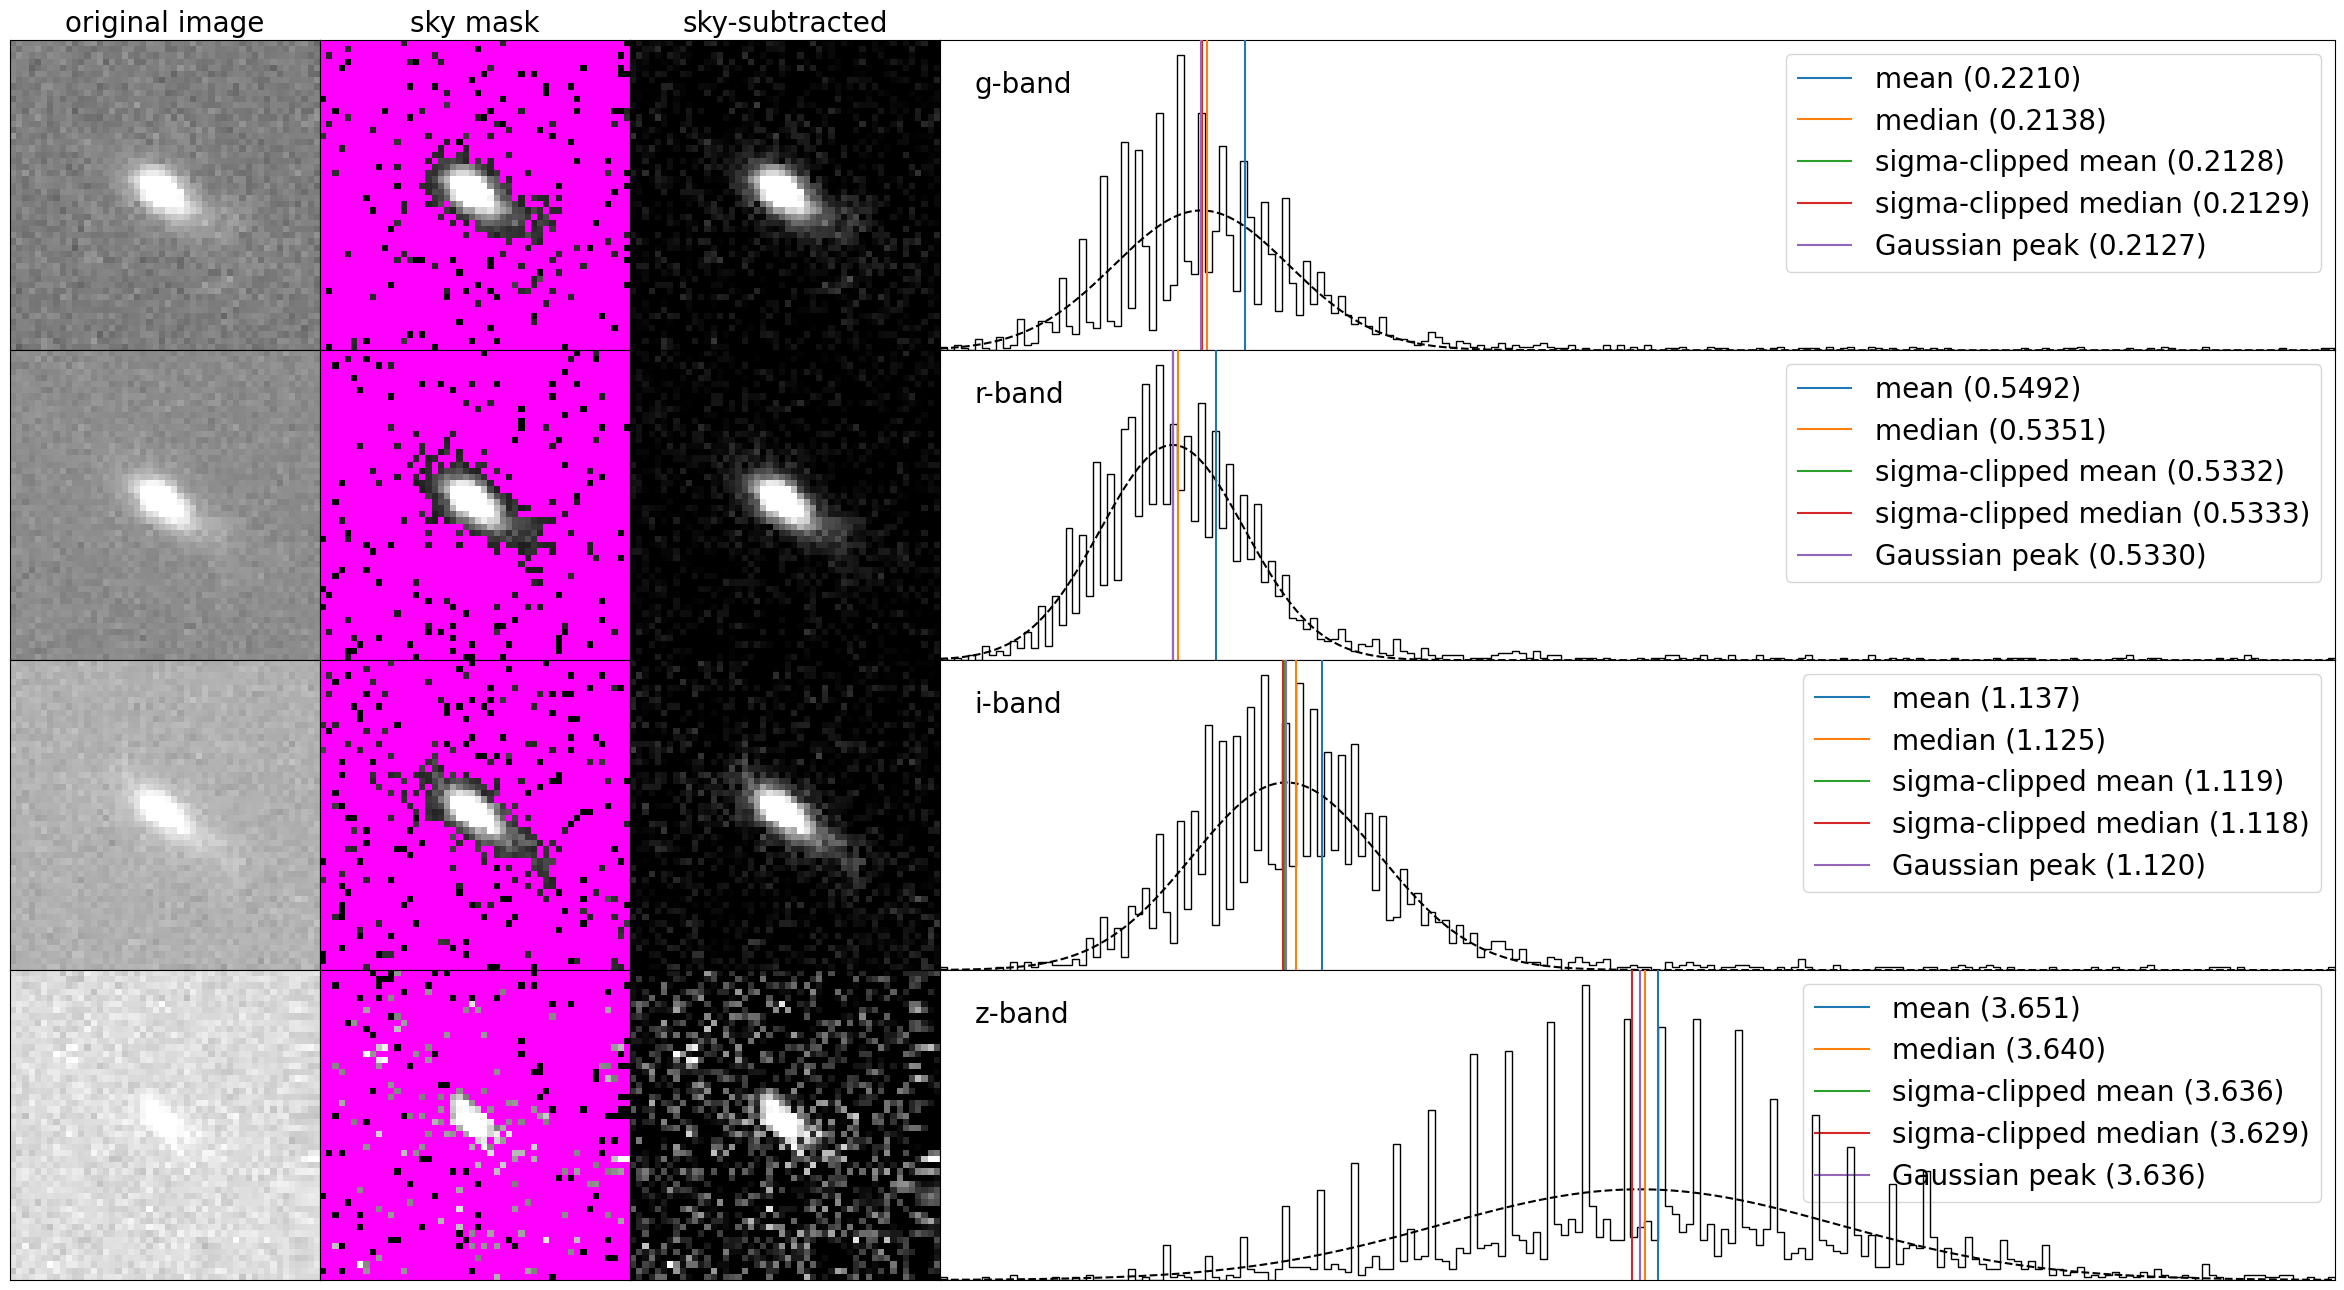

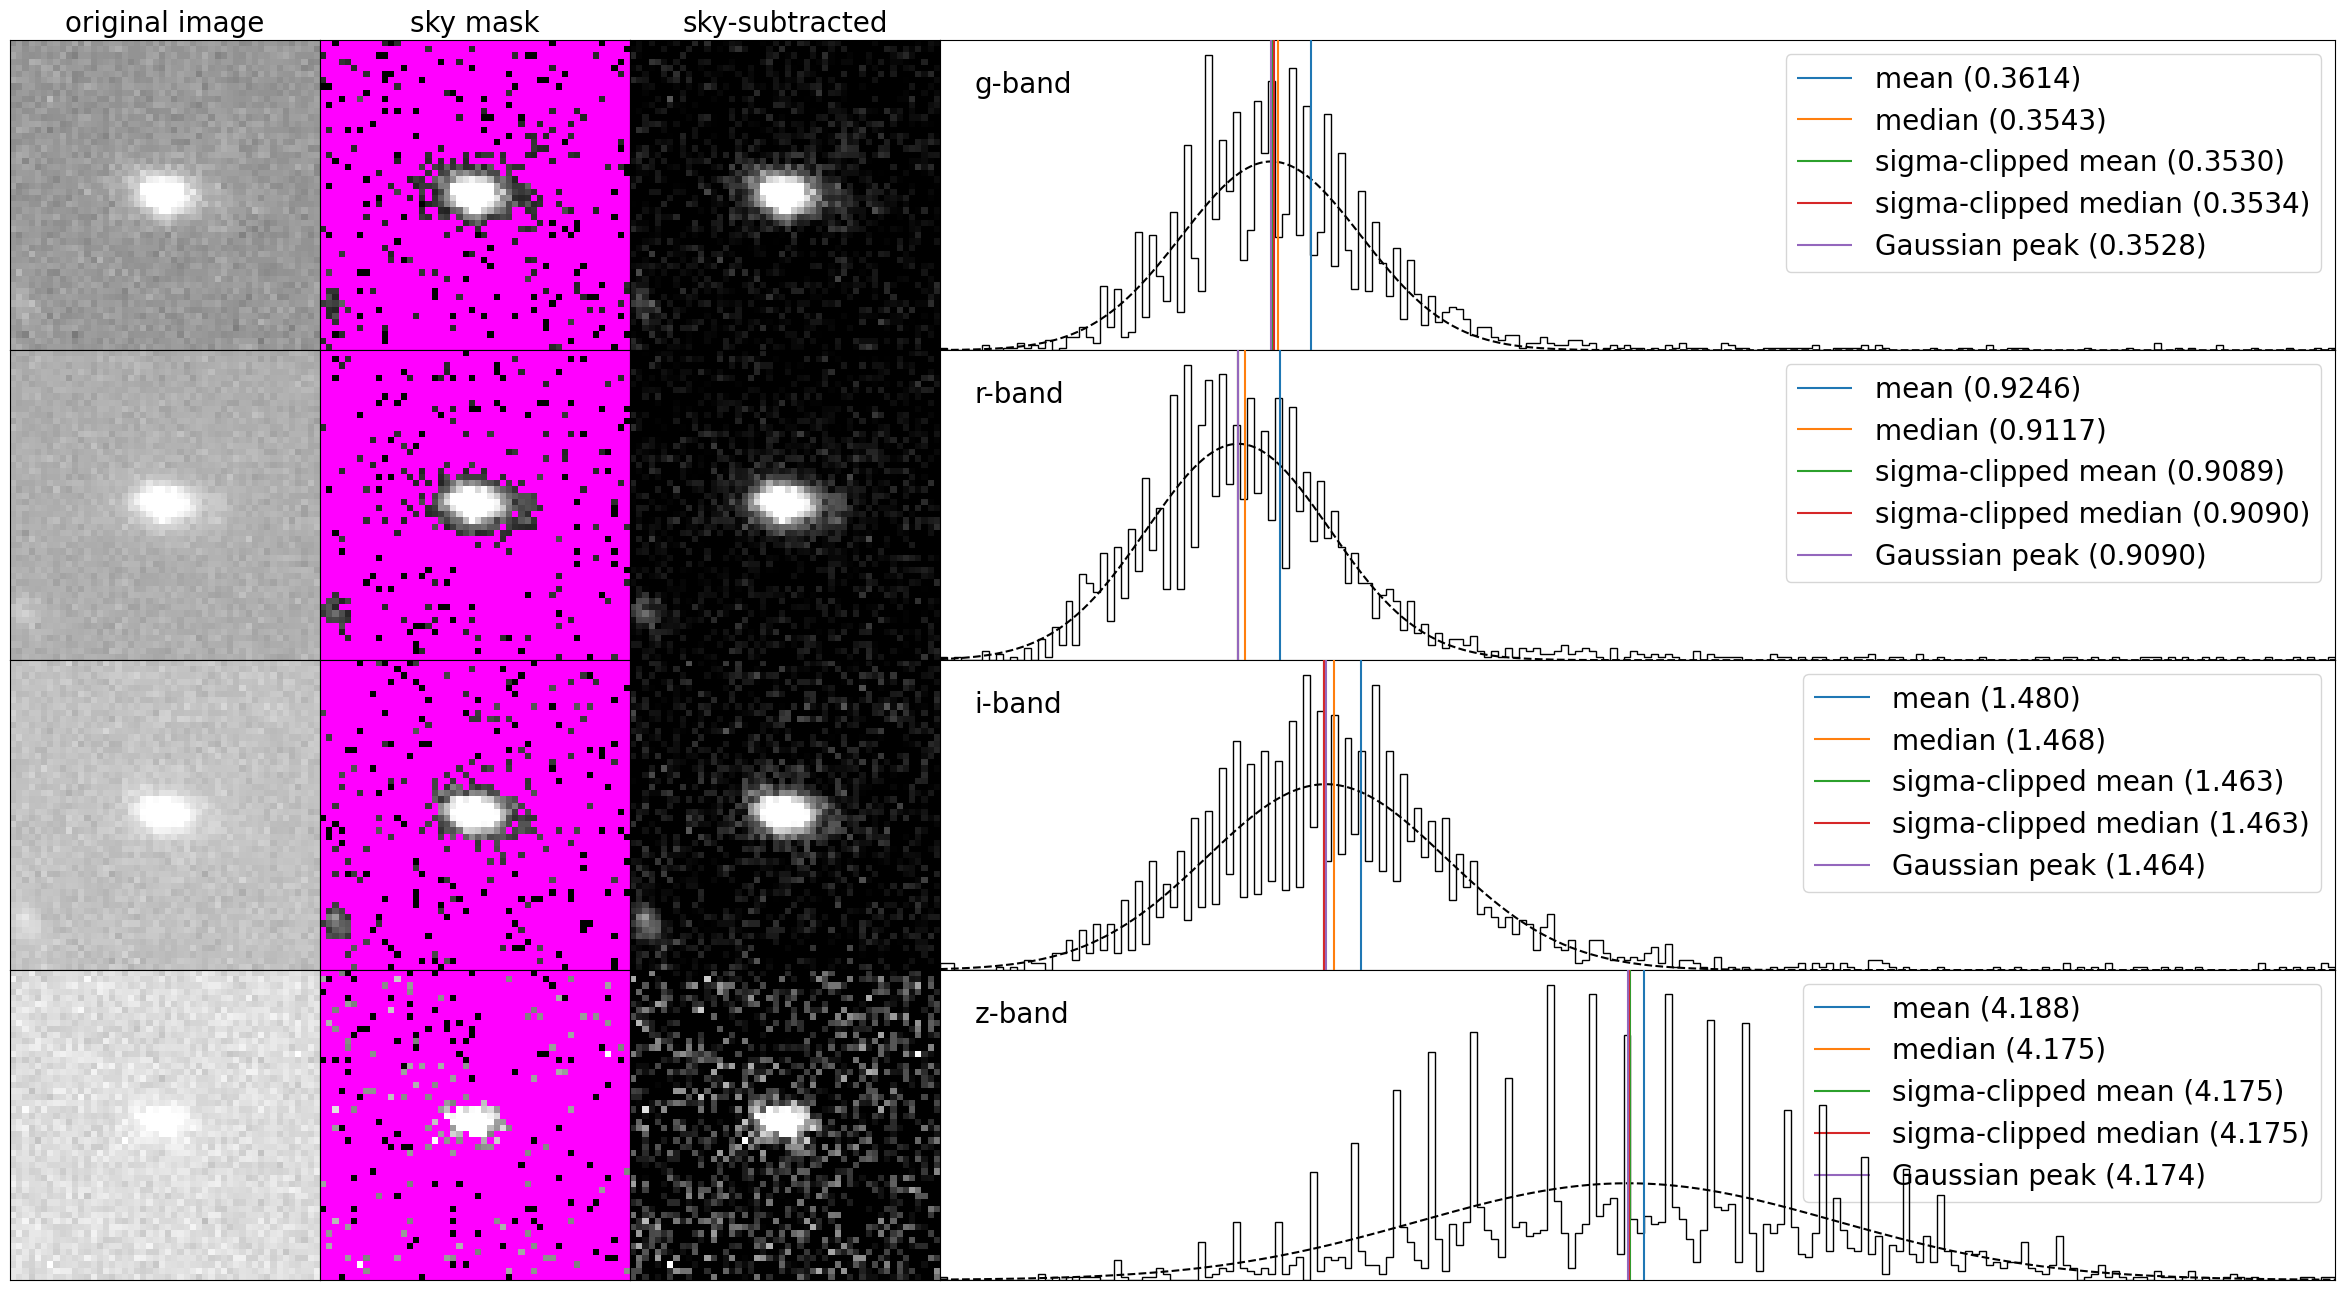

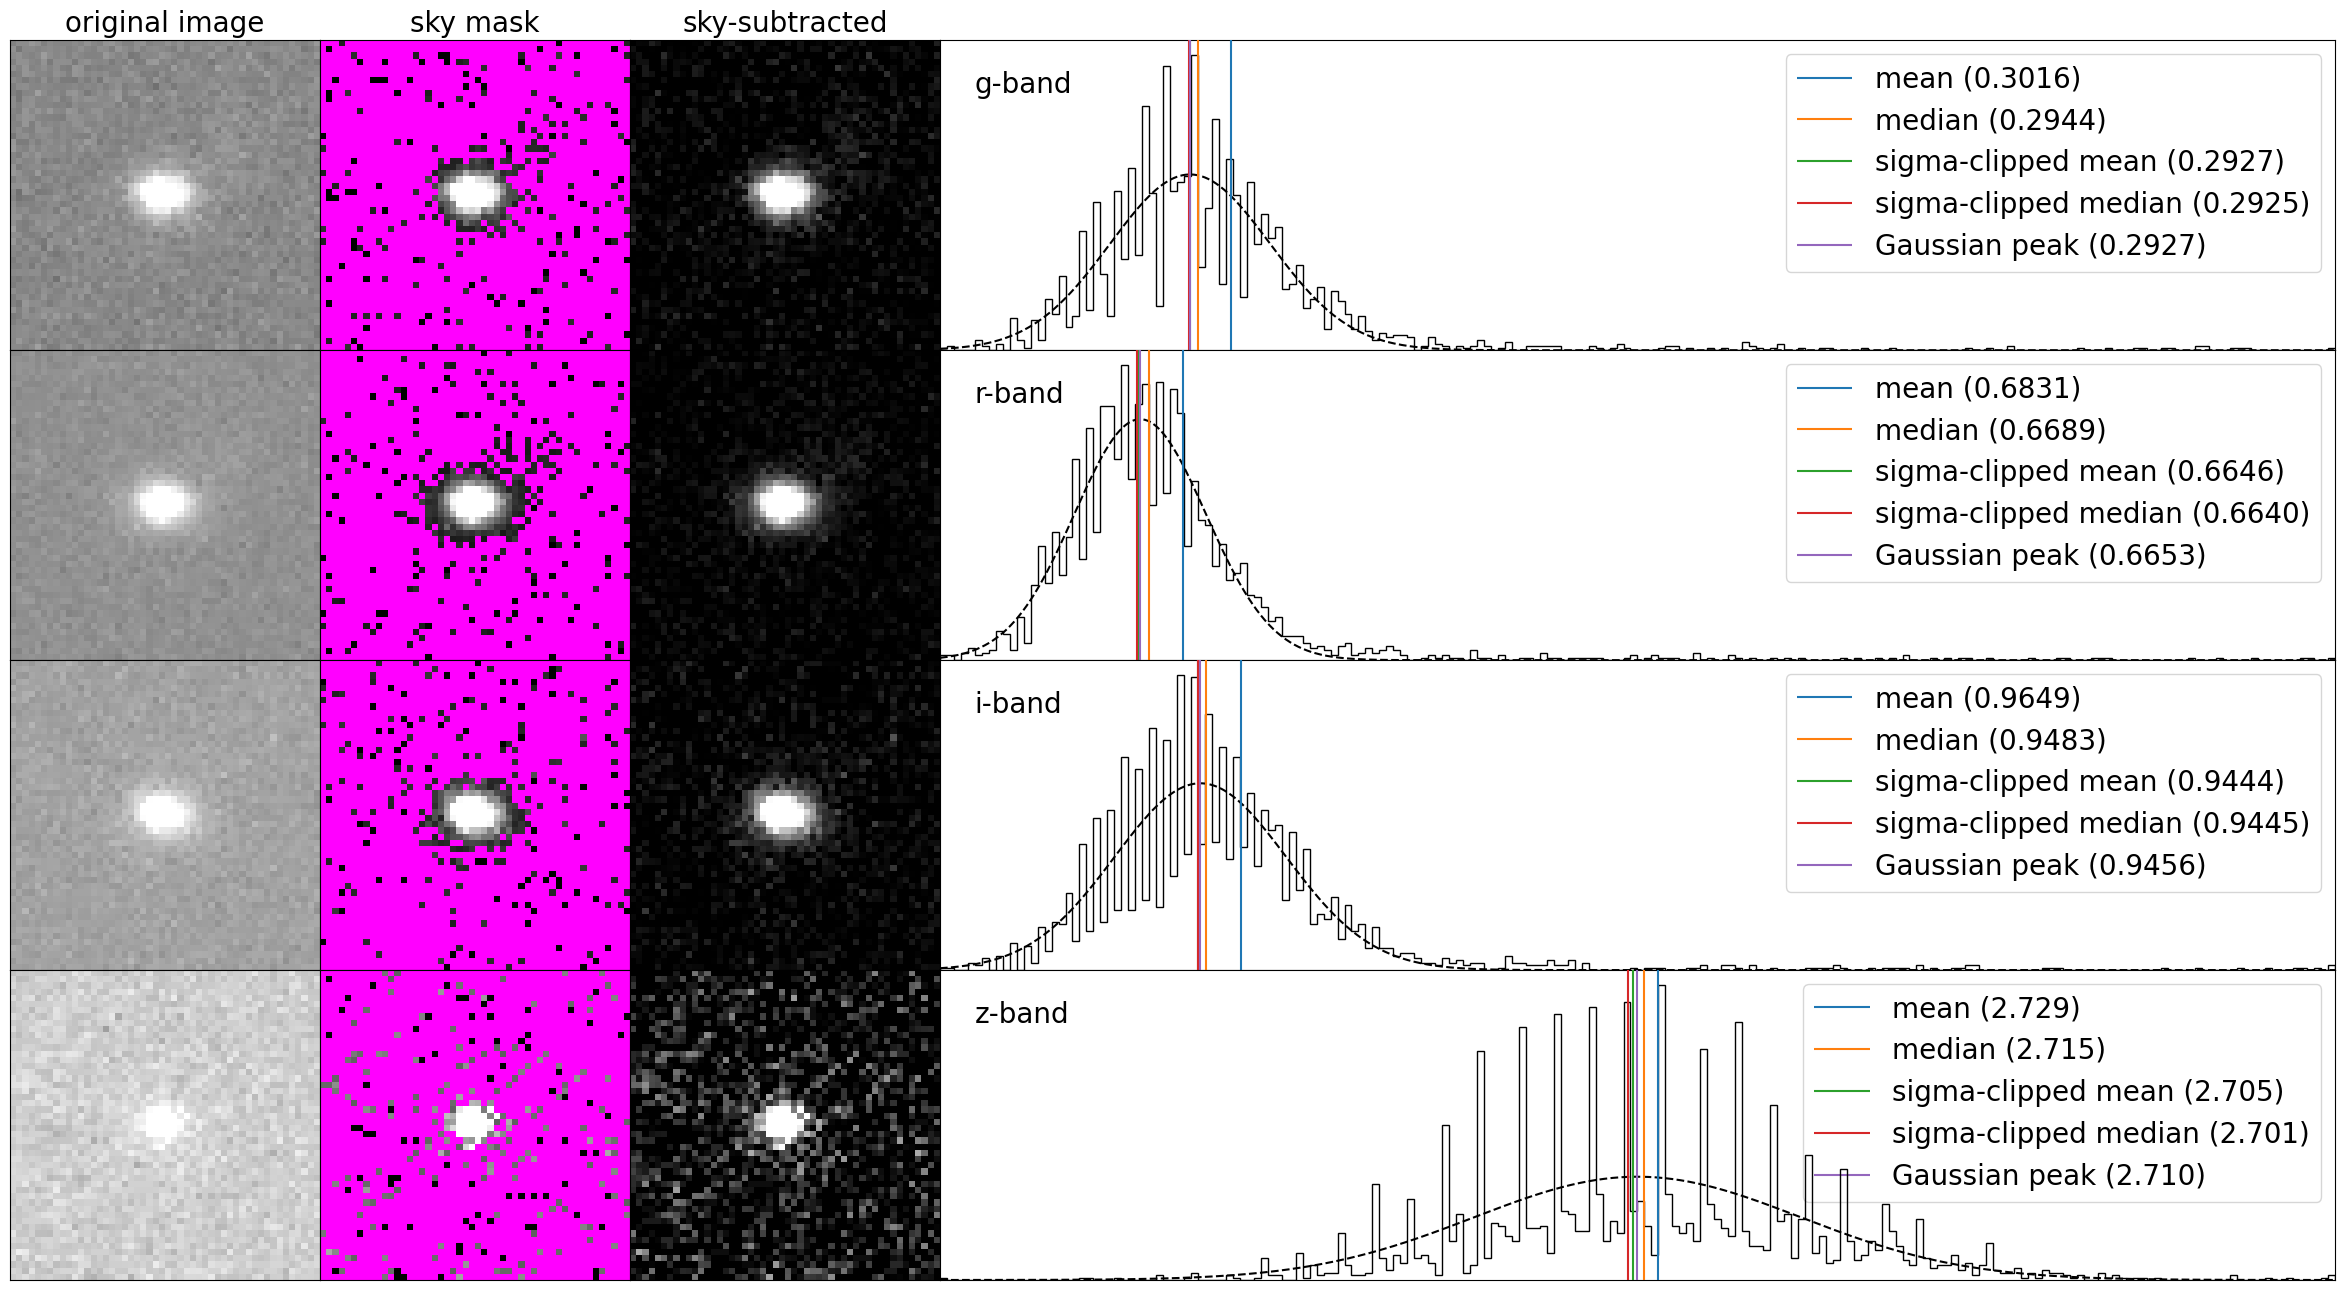

In [4]:
# ok let's try for one of the realistic TNG galaxies
fname = np.random.choice(glob.glob('tng/*.fits'))
hdr = fits.getheader(fname)
print('Galaxy ID: %d\n' %(hdr['snapshot']*1e7+hdr['subhaloID']))
print('   Time since last merger: %g Gyr' %hdr['dt_last'])
print('Time since biggest merger: %g Gyr\n' %hdr['dt_biggest'])
print('   Mass ratio of last merger: %g' %hdr['ratio_last'])
print('Mass ratio of biggest merger: %g\n' %hdr['ratio_biggest'])

# I was apparently not clever enough to put the bands in the header
for i in range(1,4):
    fig = visualise_sky(fits.getdata(fname, ext=i), bands='griz')

Galaxy ID: 1131679351373925

Galaxy Zoo Classifications:

          Elliptical:   0%
    Clockwise spiral: 100%
Anticlockwise spiral:   0%
      Edge-on spiral:   0%
              Merger:   0%
          Don't know:   0%

     Number of votes: 26

Input size:       9025
Number of clips:  6
Final data size:  6437
Median:           0.279328
Mean:             0.279433
Sigma:            0.00768991


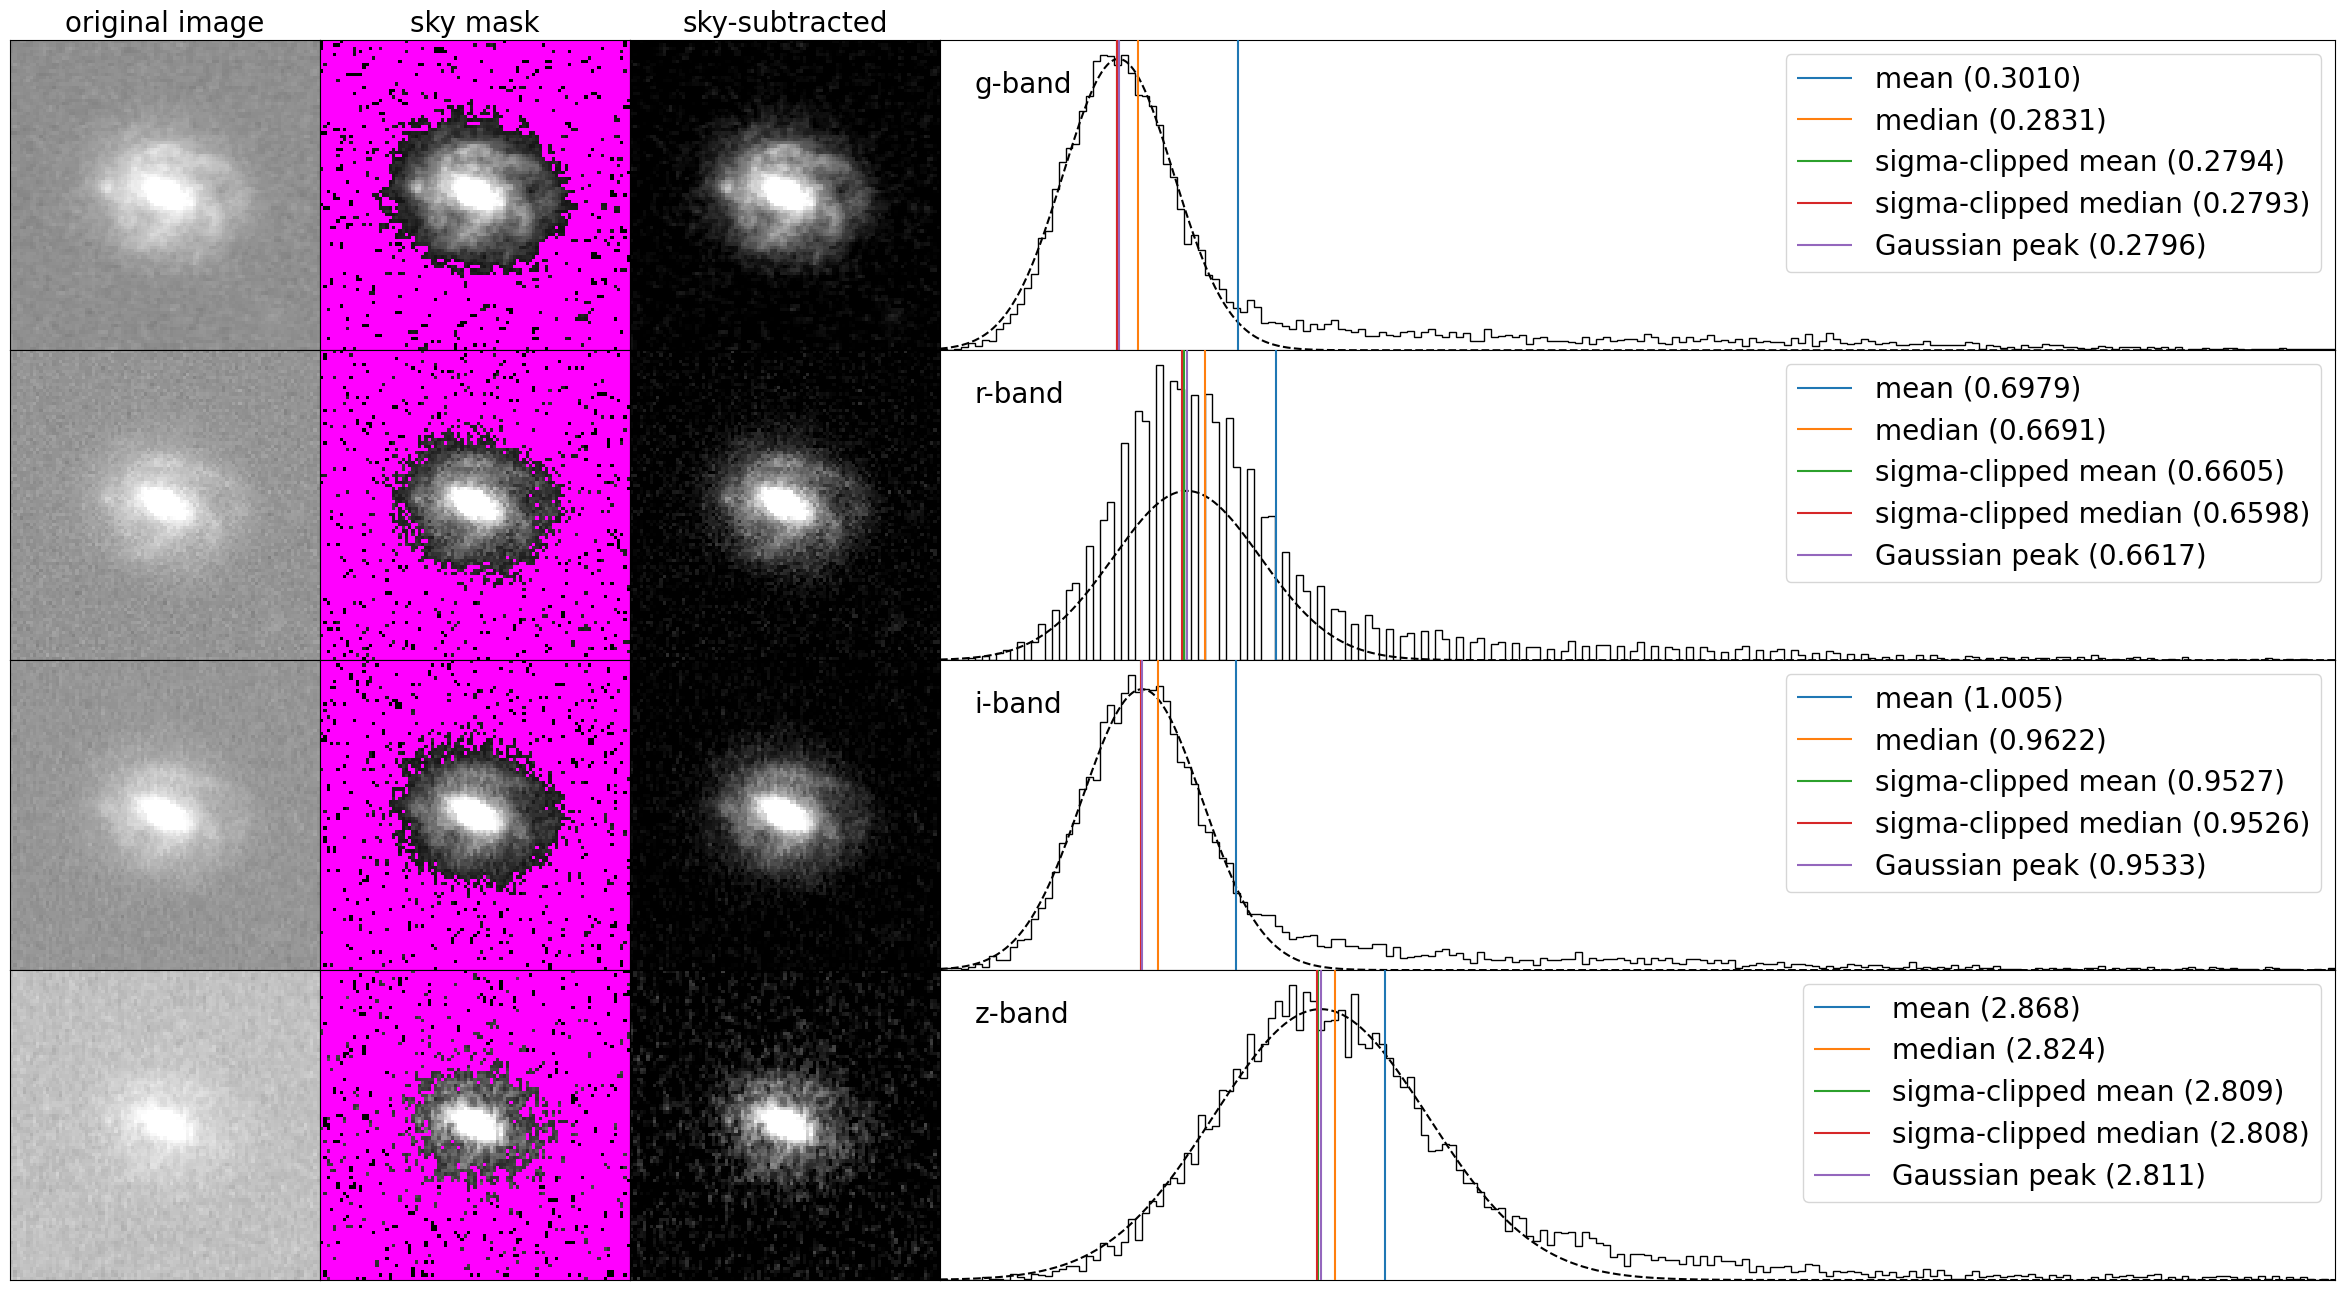

In [5]:
# now one of the real SDSS galaxies
fname = np.random.choice(np.concatenate([glob.glob('agn/*'), glob.glob('control-large/*')]))

hdr = fits.getheader(fname)
print('Galaxy ID: %d\n' %hdr['objid'])
print('Galaxy Zoo Classifications:\n')
print('          Elliptical: %3d%%' %(hdr['p_el']*100))
print('    Clockwise spiral: %3d%%' %(hdr['p_cw']*100))
print('Anticlockwise spiral: %3d%%' %(hdr['p_acw']*100))
print('      Edge-on spiral: %3d%%' %(hdr['p_edge']*100))
print('              Merger: %3d%%' %(hdr['p_mg']*100))
print("          Don't know: %3d%%\n" %(hdr['p_dk']*100))
print('     Number of votes: %d\n' %hdr['nvote'])

fig = visualise_sky(fits.getdata(fname), bands=hdr['bands'])